# Trajectoy inference on the imputed B cell data

In [1]:
import scanpy as sc
import anndata as ad
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import cellrank as cr
import scvelo as scv
import palantir
import matplotlib
import cytovi

In [2]:
# load data
os.chdir('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure3/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)
sc.settings.n_jobs = 60
adata = ad.read_h5ad('../data/raw/CyTOF/Glass_B_cells/2024-08-15_B_cells_preprocessed_combined_subsampled_48k_imputed_annotated.h5ad')

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


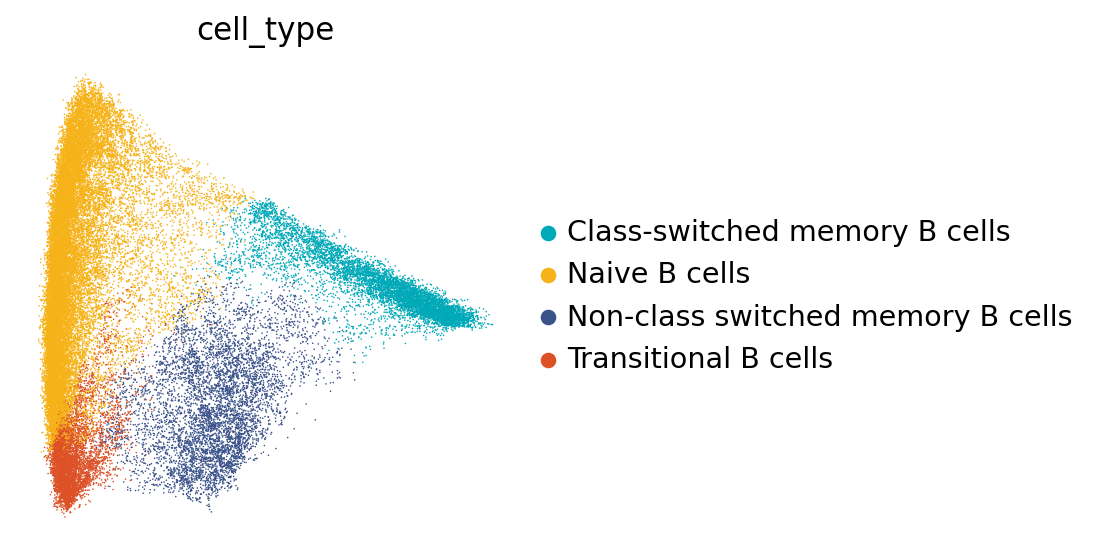

In [3]:
cell_type_colors = {
            'Transitional B cells': '#DD5126',
            'Naive B cells': '#F6B319',
            'Class-switched memory B cells': '#00A9B8',
            'Non-class switched memory B cells': '#3A528A'
            }
sc.pl.embedding(adata, basis='X_diffmap', color='cell_type', dimensions=(1,2), palette = cell_type_colors, save = 'diffmap_cell_type.png', s = 2, frameon = False)

# Compute palantir pseudotime

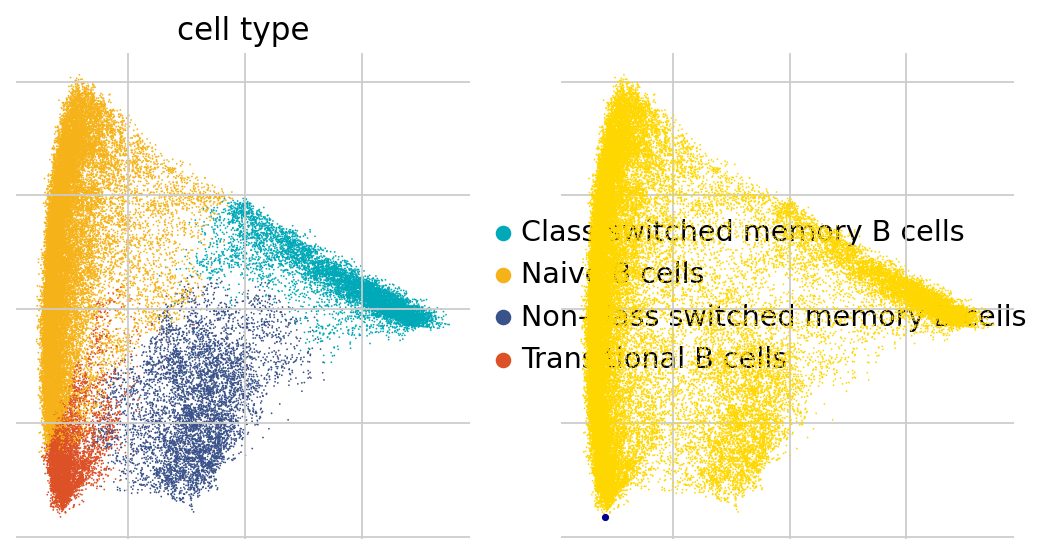

In [4]:
# identify root cell
root_id = adata.obsm['X_diffmap'][:, 2].argmin()
scv.pl.scatter(
    adata,
    basis="diffmap",
    c=["cell_type", root_id],
    legend_loc="right",
    components=["1, 2"],
)

adata.uns["iroot"] = root_id

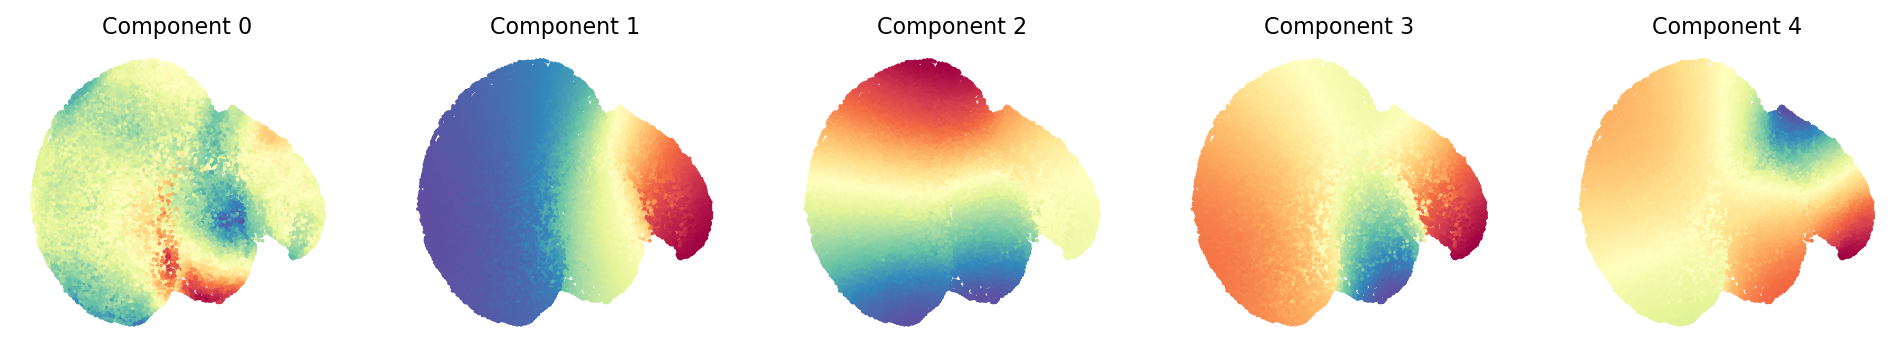

In [5]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)

ms_data = palantir.utils.determine_multiscale_space(adata)

palantir.plot.plot_diffusion_components(adata)
plt.show()

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


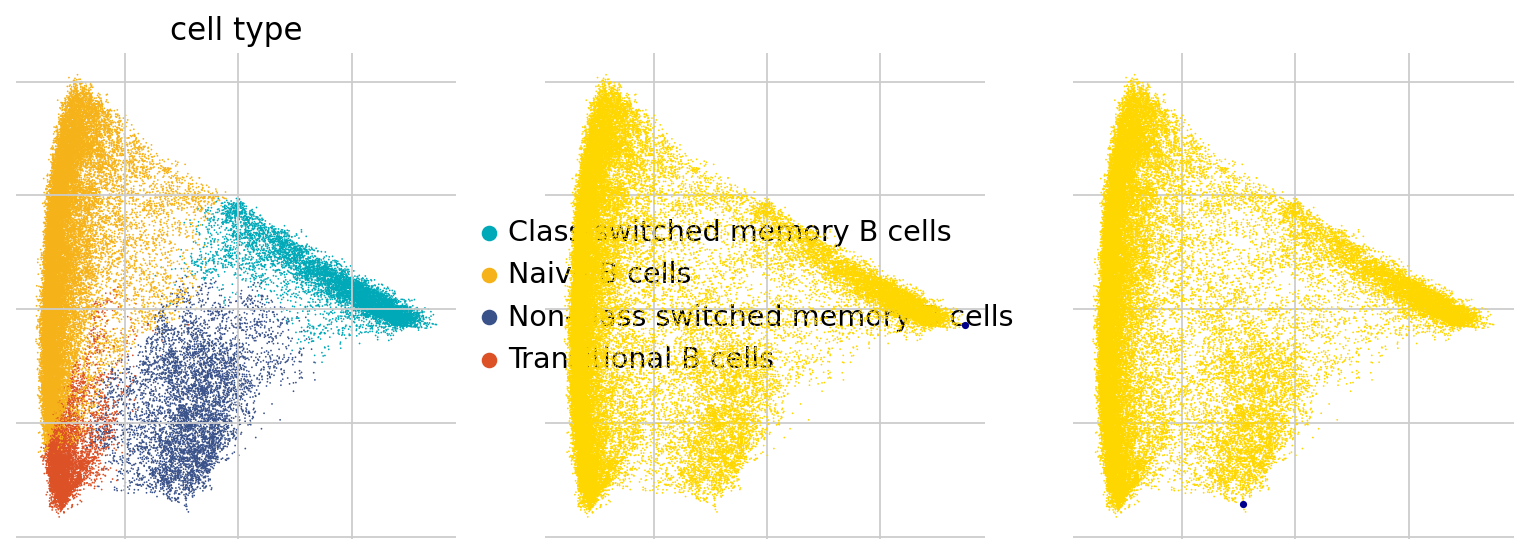

In [8]:
# set terminal states
term_CSM = adata[adata.obs['cell_type'] == 'Class-switched memory B cells'].obsm['X_diffmap'][:, 1].argmax()
term_CSM = adata[adata.obs['cell_type'] == 'Class-switched memory B cells'].obs.index[term_CSM]
term_CSM_ind = [index for index, value in enumerate(adata.obs_names) if value == term_CSM]

term_NCSM = adata[adata.obs['cell_type'] == 'Non-class switched memory B cells', 'CD27'].X.argmax()
term_NCSM = adata[adata.obs['cell_type'] == 'Non-class switched memory B cells'].obs.index[term_NCSM]
term_NCSM_ind = [index for index, value in enumerate(adata.obs_names) if value == term_NCSM]

terminal_states = pd.Series(
        ['Class-switched memory B cells', 'Non-class switched memory B cells'],
        index= [term_CSM, term_NCSM]
        )

scv.pl.scatter(
    adata,
    basis="diffmap",
    c=["cell_type", term_CSM_ind, term_NCSM_ind],
    legend_loc="right",
    components=["1, 2"],
)

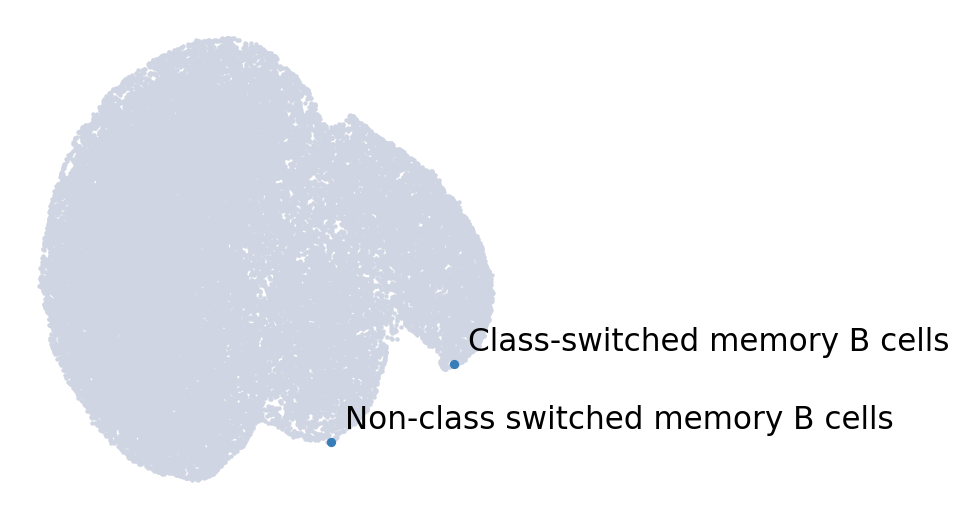

In [9]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states)
plt.show()

In [10]:
start_cell = adata.obs.index[root_id]
pr_res = palantir.core.run_palantir(
    adata, start_cell, terminal_states=terminal_states, n_jobs = 1
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.26115468740463255 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 2.0619418104489644 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


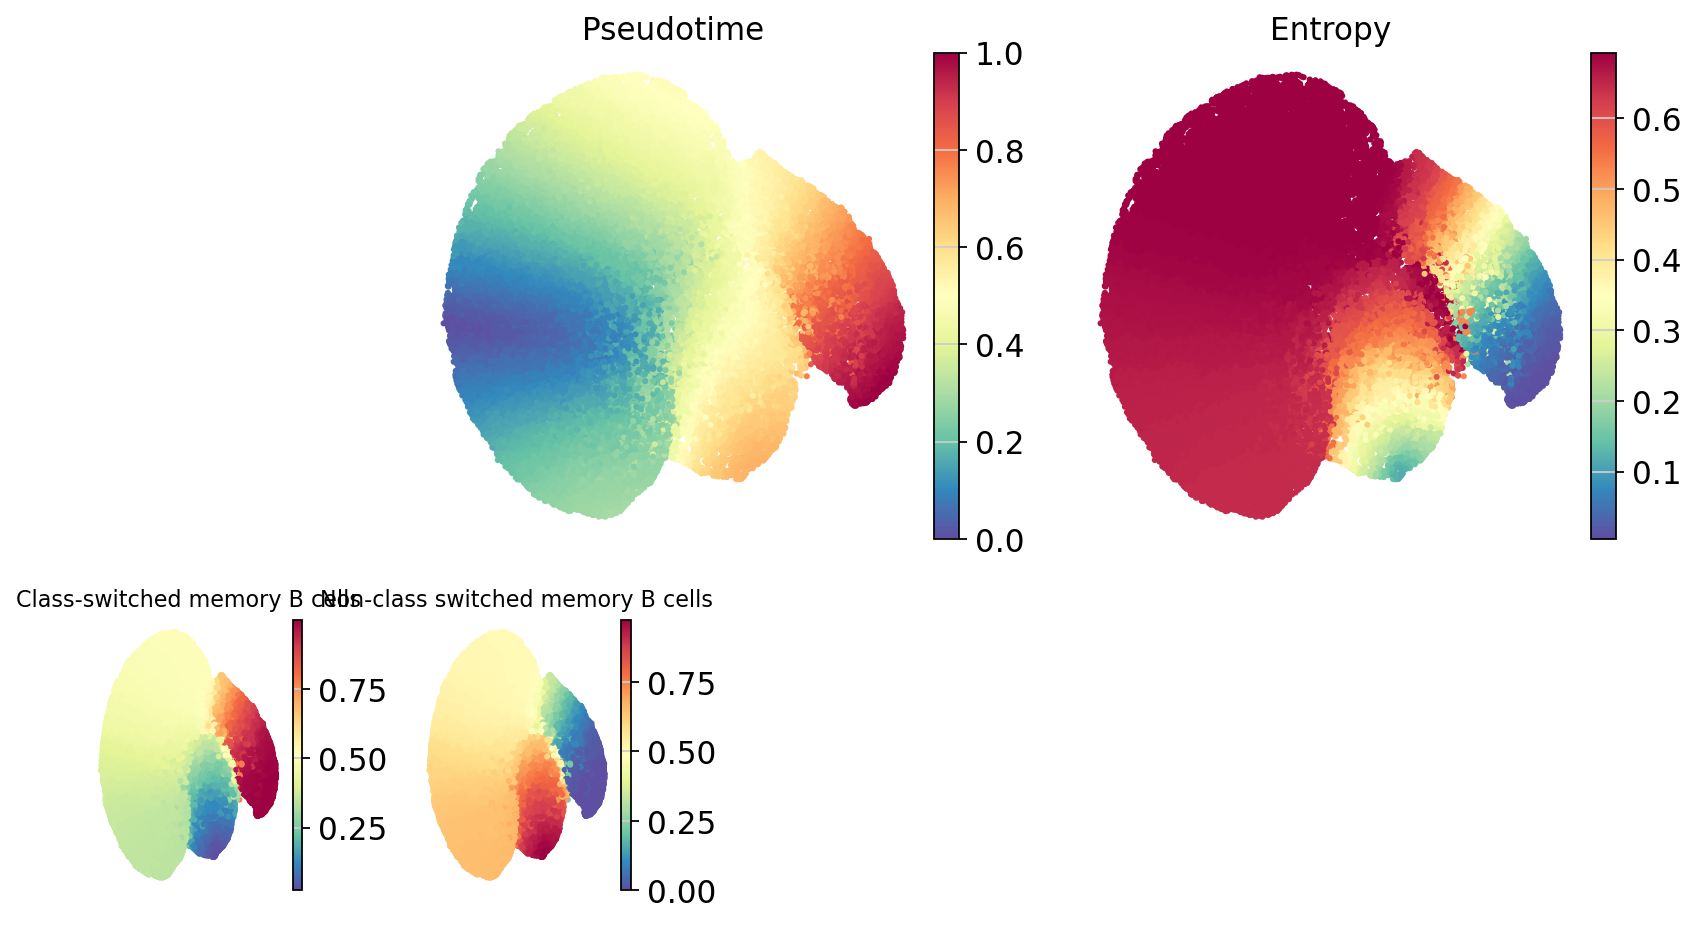

In [11]:
palantir.plot.plot_palantir_results(adata, s=3)
plt.show()

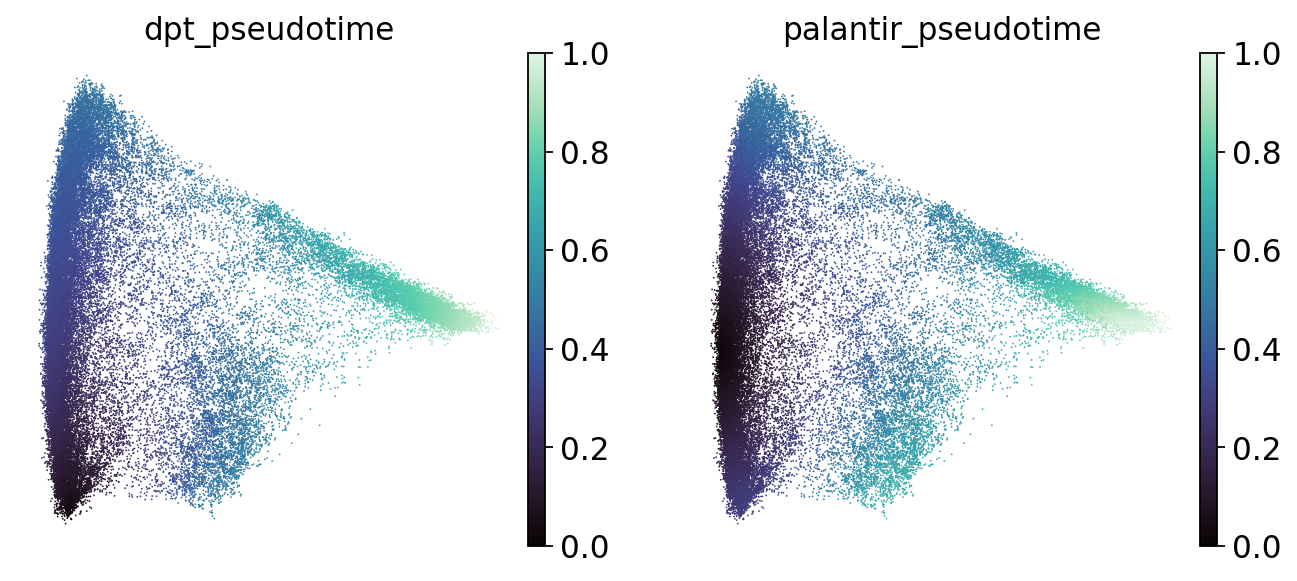

In [12]:
# compute dpt pseudotime
sc.tl.dpt(adata)

sc.pl.embedding(
    adata,
    basis="diffmap",
    color=["dpt_pseudotime", 'palantir_pseudotime'],
    color_map="mako",
    dimensions=[1, 2],
    frameon = False,
    save = 'diffmap_pseudotime.png'
)

In [13]:
# adata.write('../data/raw/CyTOF/Glass_B_cells/2024-08-15_B_cells_preprocessed_combined_subsampled_48k_imputed_annotated_palantir_pseudotime.h5ad')

In [14]:
# load anndata again
adata = ad.read_h5ad('../data/raw/CyTOF/Glass_B_cells/2024-08-15_B_cells_preprocessed_combined_subsampled_48k_imputed_annotated_palantir_pseudotime.h5ad')

# Cellrank

In [15]:
# subsample to 10k cells to speed things up for cellrank
adata_sub = sc.pp.subsample(adata, n_obs=20000, copy=True)
sc.pp.neighbors(adata_sub)

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


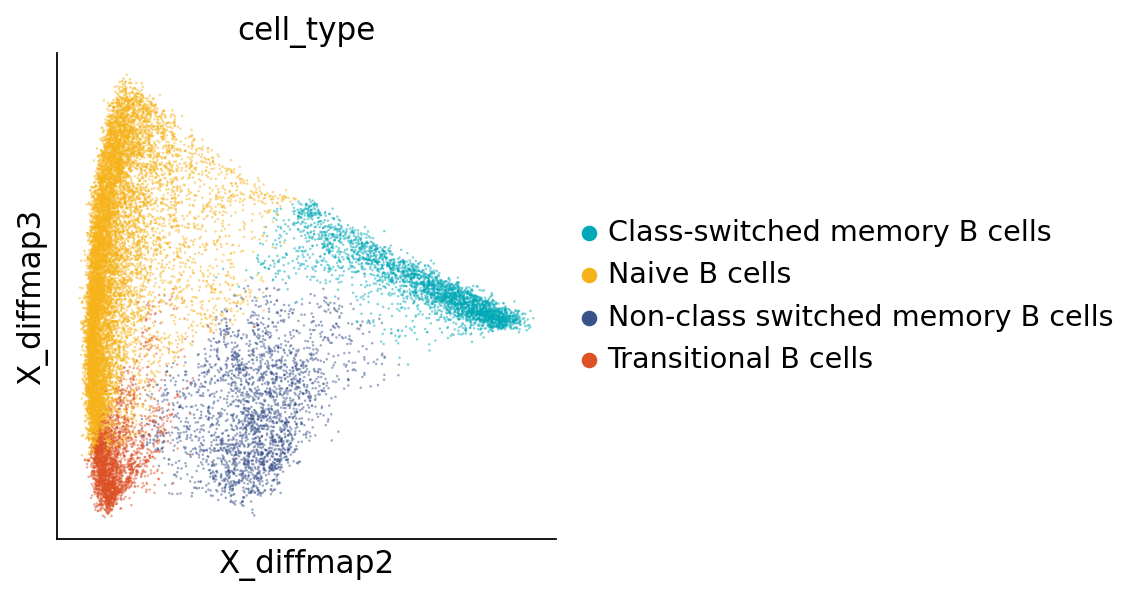

In [6]:
sc.pl.embedding(adata_sub, basis='X_diffmap', color='cell_type', dimensions=(1,2), alpha = 0.5, s = 5)

In [17]:
# initiate pseudotime kernel
pk = cr.kernels.PseudotimeKernel(adata_sub, time_key="dpt_pseudotime")
pk.compute_transition_matrix()

  0%|          | 0/20000 [00:00<?, ?cell/s]

PseudotimeKernel[n=20000, dnorm=False, scheme='hard', frac_to_keep=0.3]

saving figure to file ./figures/scvelo_diffmap_transition_matrix_arrows.pdf


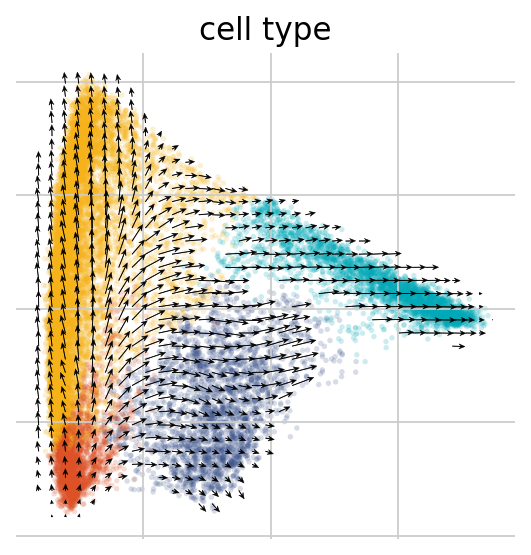

In [8]:
pk.plot_projection(basis="diffmap", recompute=False, stream=False, color = 'cell_type', arrow_length = 4, arrow_size = 2, arrow_color = 'black', smooth = 1, density = 0.7, min_mass = 10, save = 'diffmap_transition_matrix_arrows.pdf')

In [18]:
g = cr.estimators.GPCCA(pk)
print(g)

GPCCA[kernel=PseudotimeKernel[n=20000], initial_states=None, terminal_states=None]


In [19]:
g.fit(cluster_key="cell_type", n_states=[4, 21])

GPCCA[kernel=PseudotimeKernel[n=20000], initial_states=None, terminal_states=None]

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


saving figure to file ./figures/scvelo_diffmap_cellrank_macrostates.pdf


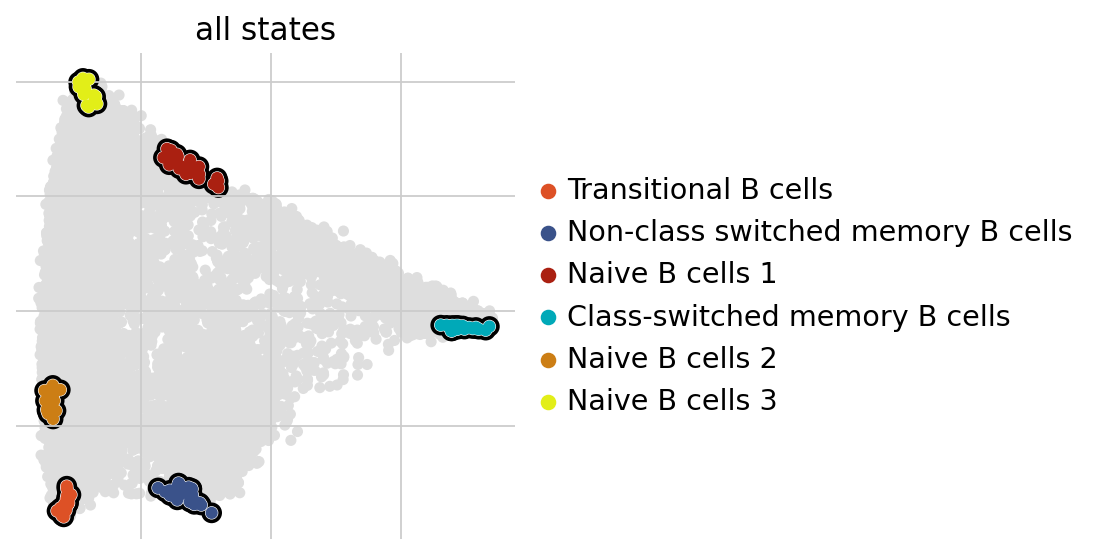

In [11]:
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100, basis='diffmap', save='diffmap_cellrank_macrostates.pdf')

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


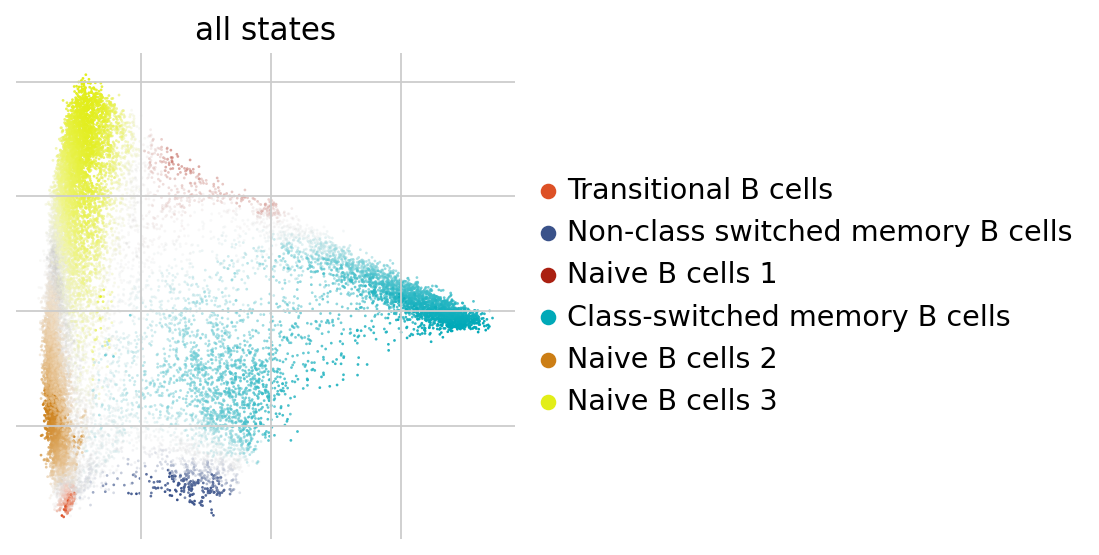

In [12]:
g.plot_macrostates(which="all", discrete=False, legend_loc="right", basis='diffmap')

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


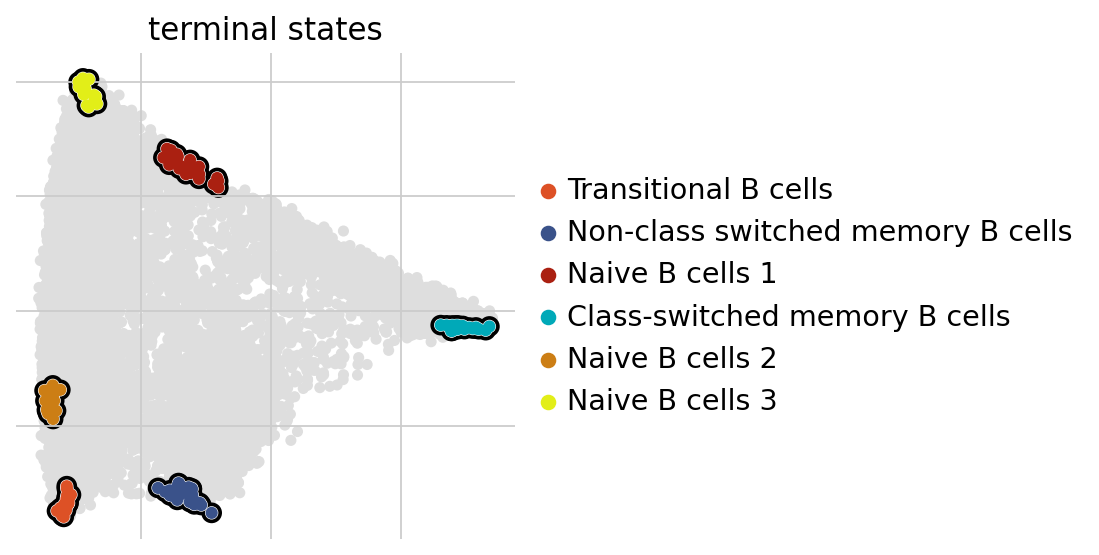

In [22]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100, basis = 'diffmap')

In [23]:
# manually set terminal states
g.set_terminal_states(states = ['Class-switched memory B cells', 'Non-class switched memory B cells'])

GPCCA[kernel=PseudotimeKernel[n=20000], initial_states=None, terminal_states=['Class-switched memory B cells', 'Non-class switched memory B cells']]

/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_diffmap_cellrank_terminal_states.pdf


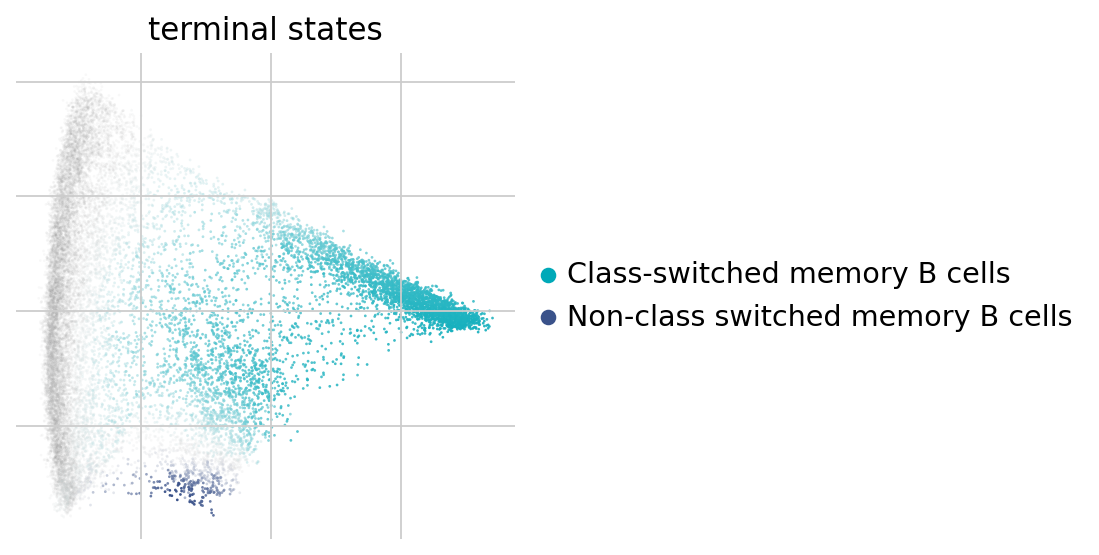

In [15]:
g.plot_macrostates(which="terminal", legend_loc="right", basis = 'diffmap', discrete=False, save = 'diffmap_cellrank_terminal_states.pdf')

saving figure to file ./figures/scvelo_diffmap_cellrank_initial_states.pdf


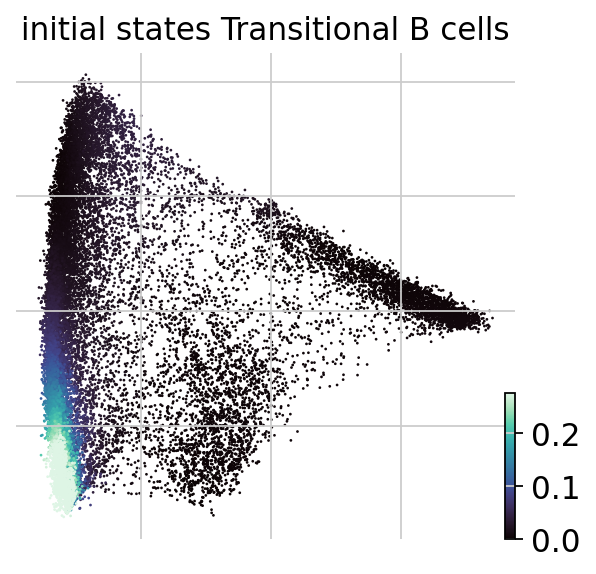

In [24]:
g.set_initial_states(states='Transitional B cells')
g.plot_macrostates(which="initial", basis = 'diffmap', discrete=False, cmap = 'mako', save = 'diffmap_cellrank_initial_states.pdf')

  0%|          | 0/2 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


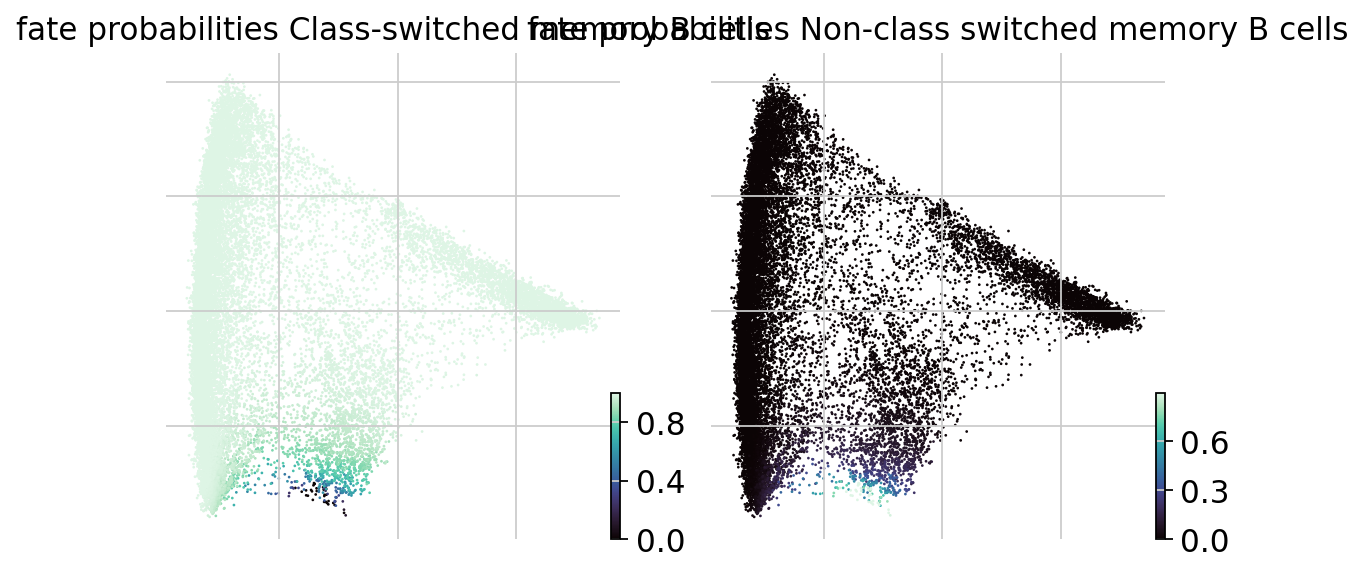

In [25]:
# visualize fate probs
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False, basis = 'diffmap', cmap = 'mako')

In [26]:
CSM_drivers_df = g.compute_lineage_drivers(
    lineages=["Class-switched memory B cells"], cluster_key="clusters"
)
CSM_drivers_df.head(10)

Class-switched memory B cells_corr  \
CD36                              0.477294   
CD244                             0.417497   
CD73                              0.397955   
SSEA_5                            0.367683   
CD23                              0.351105   
CX3CR1                            0.342709   
CD275                             0.341912   
CD215                             0.330284   
CD351                             0.321251   
CD300e                            0.312498   

        Class-switched memory B cells_pval  \
CD36                                   0.0   
CD244                                  0.0   
CD73                                   0.0   
SSEA_5                                 0.0   
CD23                                   0.0   
CX3CR1                                 0.0   
CD275                                  0.0   
CD215                                  0.0   
CD351                                  0.0   
CD300e                                 0.0   

        Class-switched memory B cells_qval  \
CD36                                   0.0   
CD244                                  0.0   
CD73                                   0.0   
SSEA_5                                 0.0   
CD23                                   0.0   
CX3CR1                                 0.0   
CD275                                  0.0   
CD215                                  0.0   
CD351                                  0.0   
CD300e                                 0.0   

        Class-switched memory B cells_ci_low  \
CD36                                0.466520   
CD244                               0.405986   
CD73                                0.386226   
SSEA_5                              0.355636   
CD23                                0.338895   
CX3CR1                              0.330420   
CD275                               0.329615   
CD215                               0.317880   
CD351                               0.308767   
CD300e                              0.299938   

        Class-switched memory B cells_ci_high  
CD36                                 0.487925  
CD244                                0.428874  
CD73                                 0.409555  
SSEA_5                               0.379608  
CD23                                 0.363197  
CX3CR1                               0.354883  
CD275                                0.354094  
CD215                                0.342575  
CD351                                0.333625  
CD300e                               0.324950

In [19]:
# remove lowly expressed markers
rm_markers = ['TCR_Vd2', 'TCR_Vb13_2']
CSM_marker = [*CSM_drivers_df.head(50).index]
CSM_marker = [marker for marker in CSM_marker if marker not in rm_markers]

In [27]:
# create gaussian GAM
model = cr.models.GAM(adata_sub, distribution='gaussian', link='identity')

  0%|          | 0/48 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


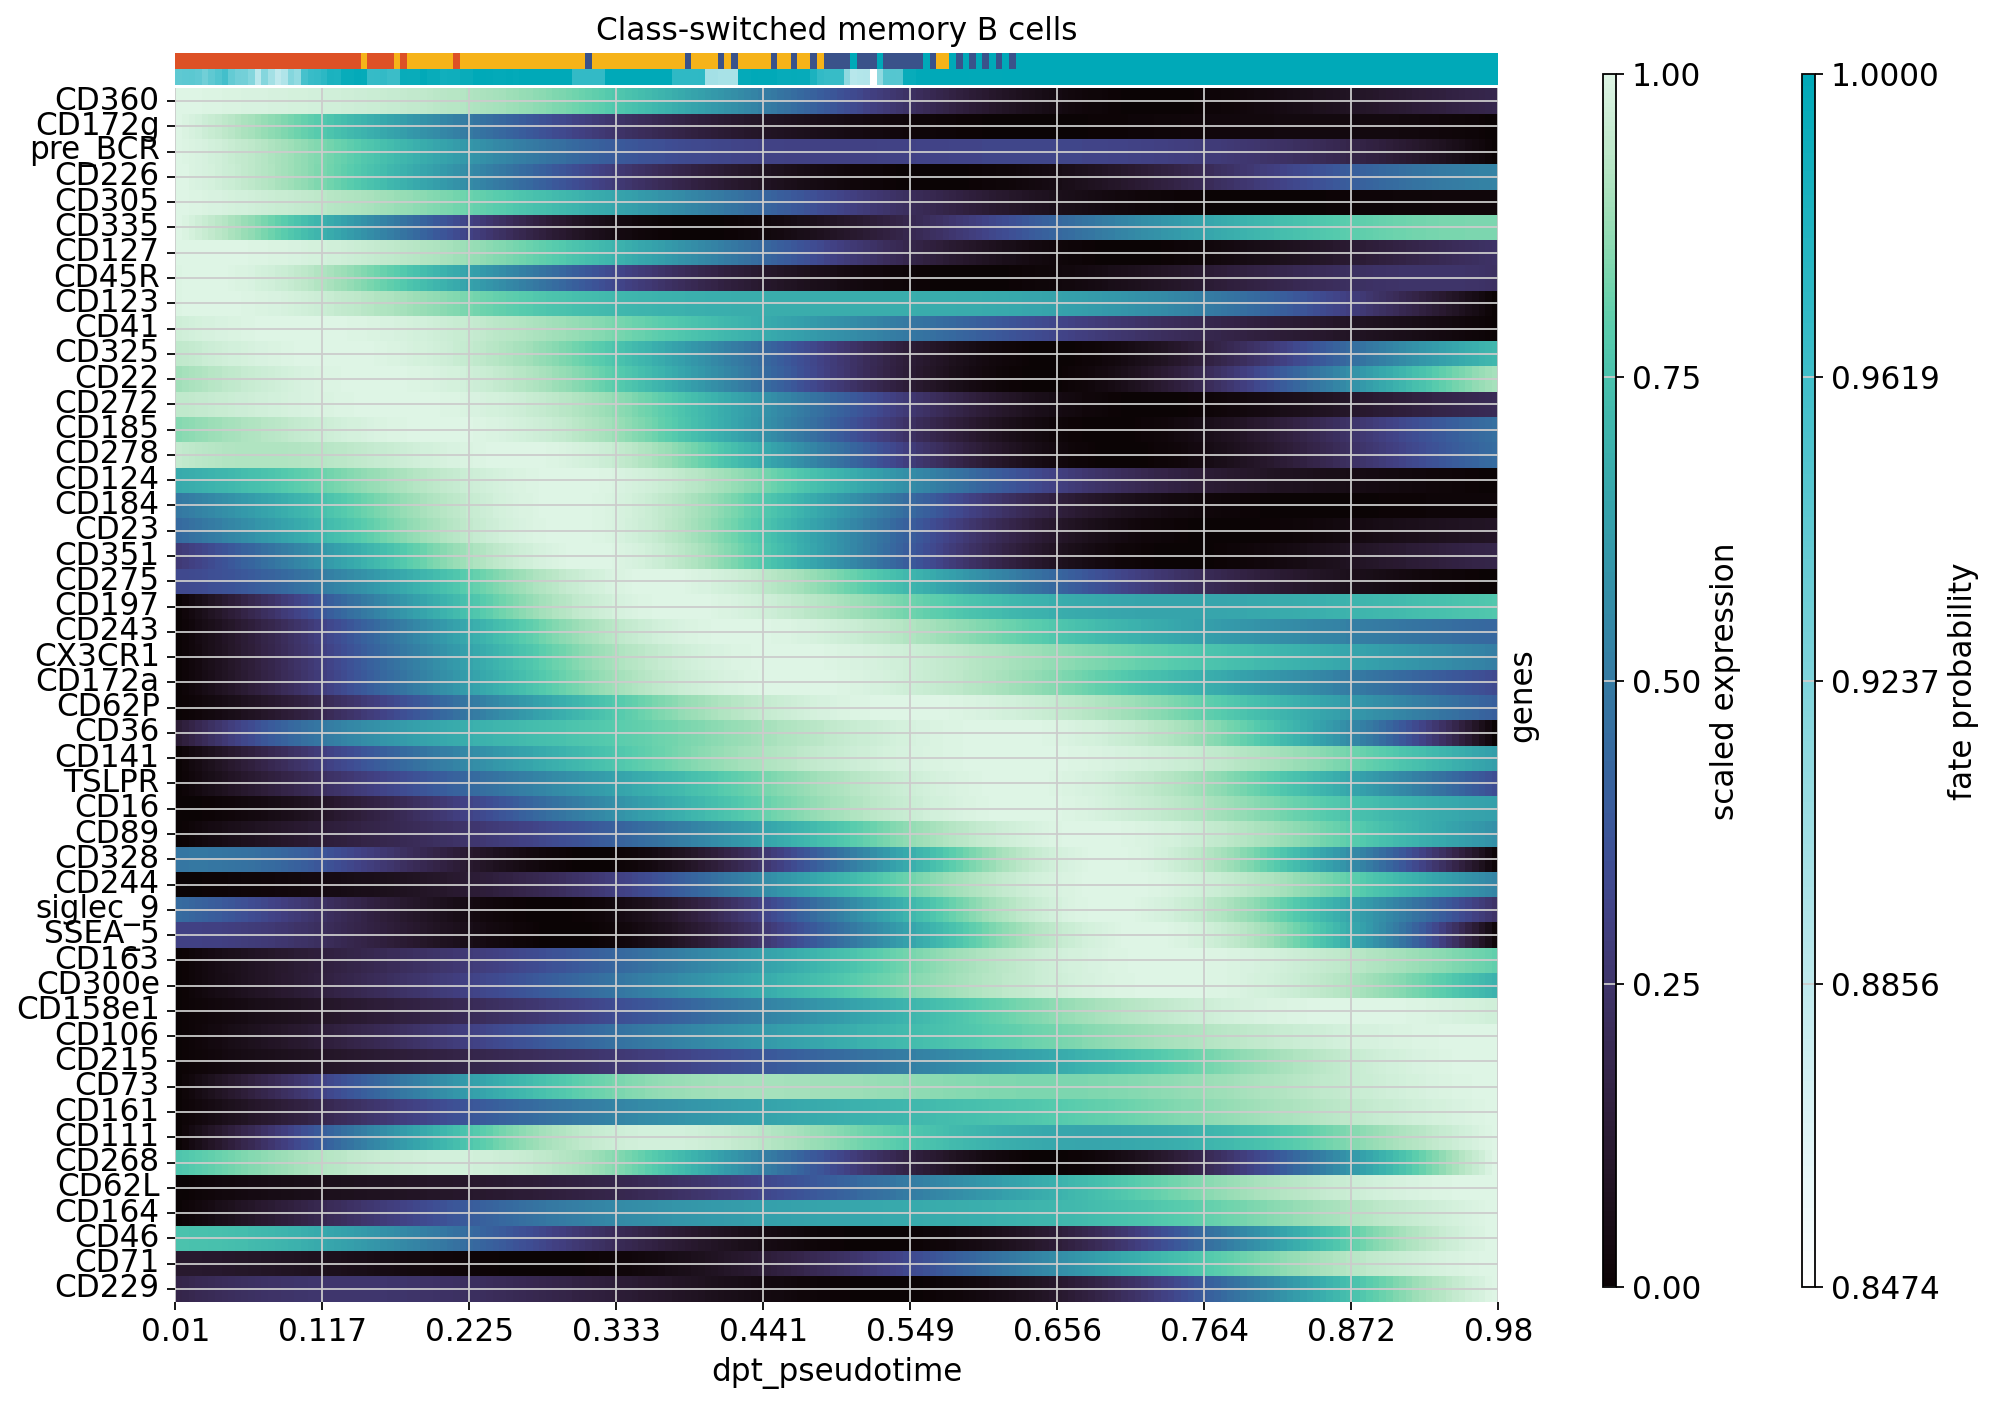

In [21]:
# plot heatmap
cr.pl.heatmap(
    adata_sub,
    model=model,
    lineages="Class-switched memory B cells",
    cluster_key="cell_type",
    show_fate_probabilities=True,
    # cluster_genes=True,
    data_key="imputed",
    genes=CSM_marker,
    time_key="dpt_pseudotime",
    keep_gene_order=True,
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
    cmap="mako",
    save = 'cellrank_heatmap_CSM.pdf'
)

# create some generic figures

<Axes: xlabel='sample_id'>

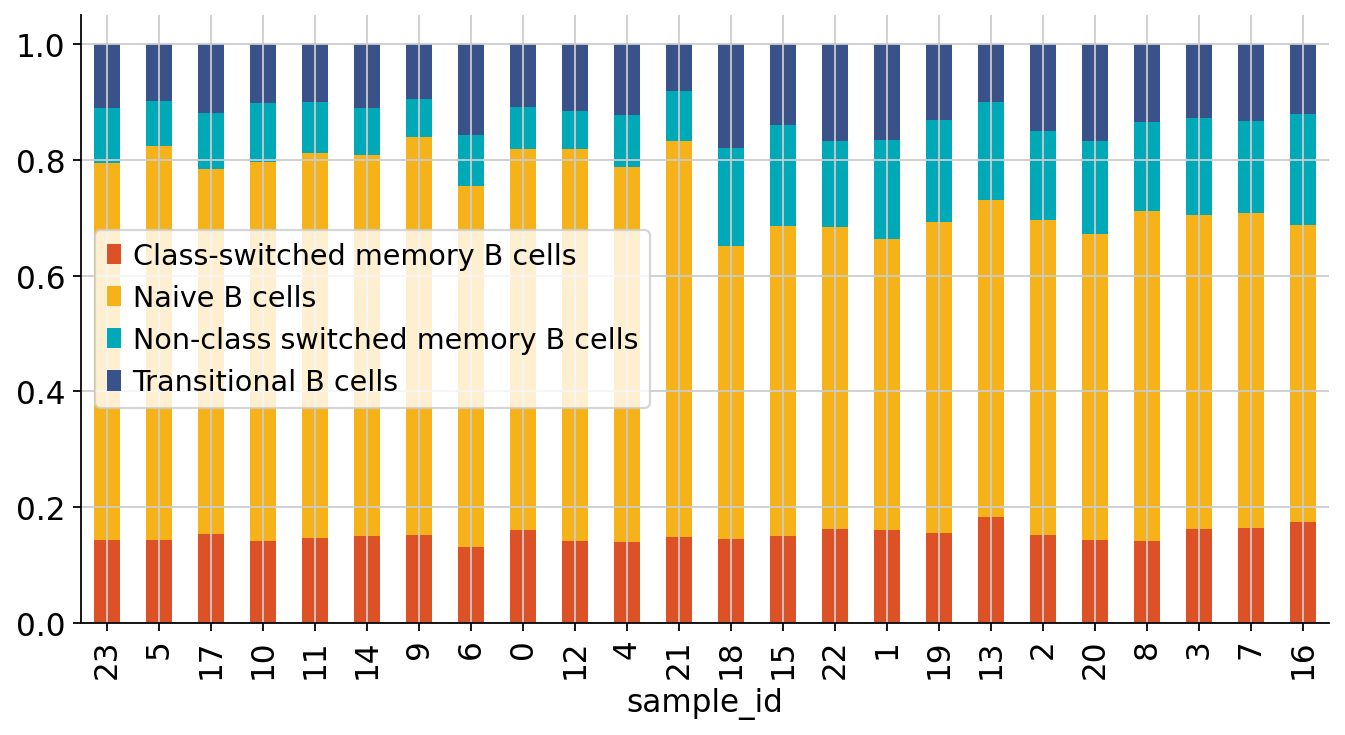

In [39]:
# Plot frequency of cell types across samples
md = adata.obs[['sample_id', 'donor', 'panel']].drop_duplicates().reset_index(drop=True)
order = md.sort_values(['donor', 'panel']).index

freq_df = adata.obs.groupby('sample_id').cell_type.value_counts(normalize=True).unstack().join(md, on='sample_id')
freq_df = freq_df.set_index('sample_id').reindex(md['sample_id'].iloc[order])

freq_df.iloc[:, 0:4].plot(kind='bar', stacked=True, figsize=(10, 5), color=cell_type_colors.values())



Wilcoxon test for Transitional B cells: p-value = 0.001
Wilcoxon test for Naive B cells: p-value = 0.000
Wilcoxon test for Non-class switched memory B cells: p-value = 0.000
Wilcoxon test for Class-switched memory B cells: p-value = 0.021


/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


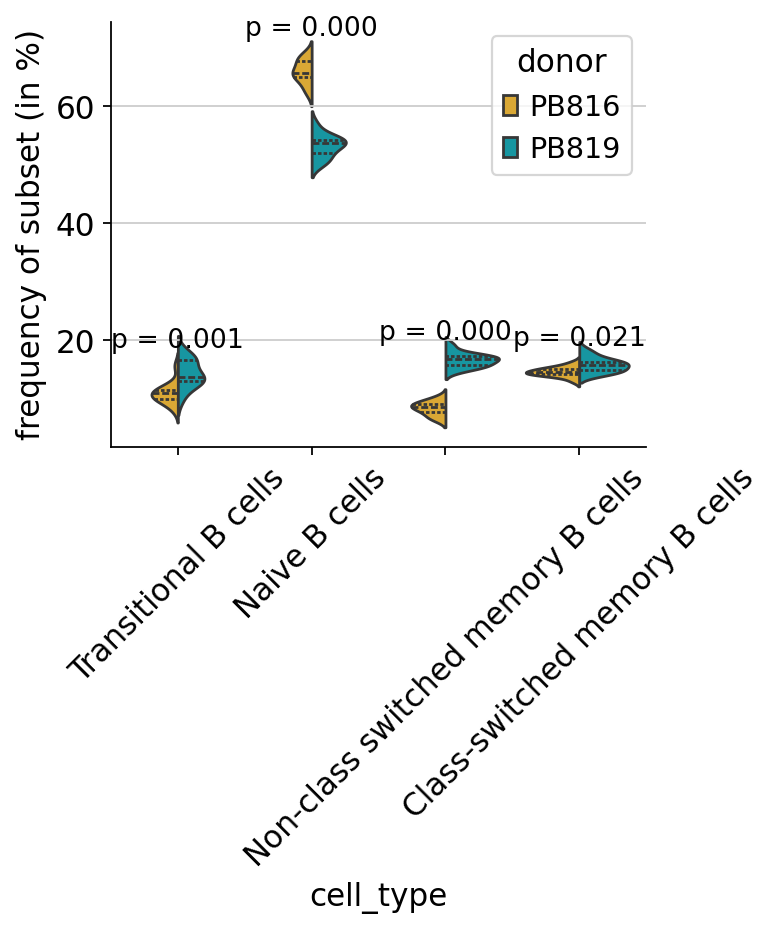

In [44]:
# Melt the dataframe for easier plotting with seaborn
melted_df = freq_df.reset_index().melt(id_vars=['sample_id', 'donor', 'panel'], 
                                        value_vars=freq_df.columns[:-2],  # Exclude metadata columns
                                        var_name='cell_type', 
                                        value_name='frequency')

melted_df['frequency'] *= 100

cell_types_order = ['Transitional B cells', 'Naive B cells', 'Non-class switched memory B cells', 'Class-switched memory B cells']

# wilcoxon tests
from scipy.stats import wilcoxon

p_values = []

# iterate over cell types
for cell_type in cell_types_order:
    subset_data = melted_df[melted_df['cell_type'] == cell_type]
    donor1 = subset_data[subset_data['donor'] == 'PB816']['frequency']
    donor2 = subset_data[subset_data['donor'] == 'PB819']['frequency']
    
    # compute stats
    stat, p_value = wilcoxon(donor1, donor2)
    p_values.append(p_value)
    print(f"Wilcoxon test for {cell_type}: p-value = {p_value:.3f}")

# plot violins
plt.figure(figsize=(5, 6))
ax = sns.violinplot(x='cell_type', y='frequency', hue='donor', data=melted_df, split=True, inner="quart", palette=['#F6B319', '#00A9B8'], order = cell_types_order)

plt.xticks(rotation=45)
plt.ylabel('frequency of subset (in %)')
plt.tight_layout()

# add pvals
for i, p_value in enumerate(p_values):
    x_position = i
    y_max = melted_df[melted_df['cell_type'] == cell_types_order[i]]['frequency'].max() * 1.05
    
    ax.text(x_position, y_max, f'p = {p_value:.3f}', ha='center', fontsize=12, color='black')

plt.savefig(figure_dir + 'violin_plot_cell_type_frequencies.pdf')

# Perform DE between class-switched and non-class switched memory B cells

In [3]:
# load model again
model_CytoVI = cytovi.CytoVI.load('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/Glass_et_all/2024-08-15_glass_48k', adata=adata)
model_CytoVI

INFO     File /home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/Glass_et_all/2024-08-15_glass_48k/model.pt       
         already downloaded                                                                                        


/home/labs/amit/floriani/mambaforge/envs/flow_py2/lib/python3.9/site-packages/scvi/model/base/_base_model.py:706: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  getattr(cls, method_name)(adata, source_registry=registry, **registry[_SETUP_ARGS_KEY])


CytoVI Model with the following params: 
n_hidden: 128, n_latent: 4, n_layers: 1, dropout_rate: 0.1, 
protein_likelihood: normal, latent_distribution: normal, 
MoG prior: False, n_labels 1, n_proteins: 350, 
Impute missing markers: True, 
Backbone markers: CD11b, CD19, CD24, CD27, CD38, CD45, CD7, IgD, IgM
Training status: Trained

In [4]:
# run DE on the generative model
de_df = model_CytoVI.differential_expression(groupby='cell_type', group1='Class-switched memory B cells', group2='Non-class switched memory B cells', batch_correction=True)

/tmp/ipykernel_1847/235603113.py:2: UserWarning: Protein expression exceeds clipping range, which can lead to poor DE results. Please adjust clipping range to data range.
  de_df = model_CytoVI.differential_expression(groupby='cell_type', group1='Class-switched memory B cells', group2='Non-class switched memory B cells', batch_correction=True)


DE...: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


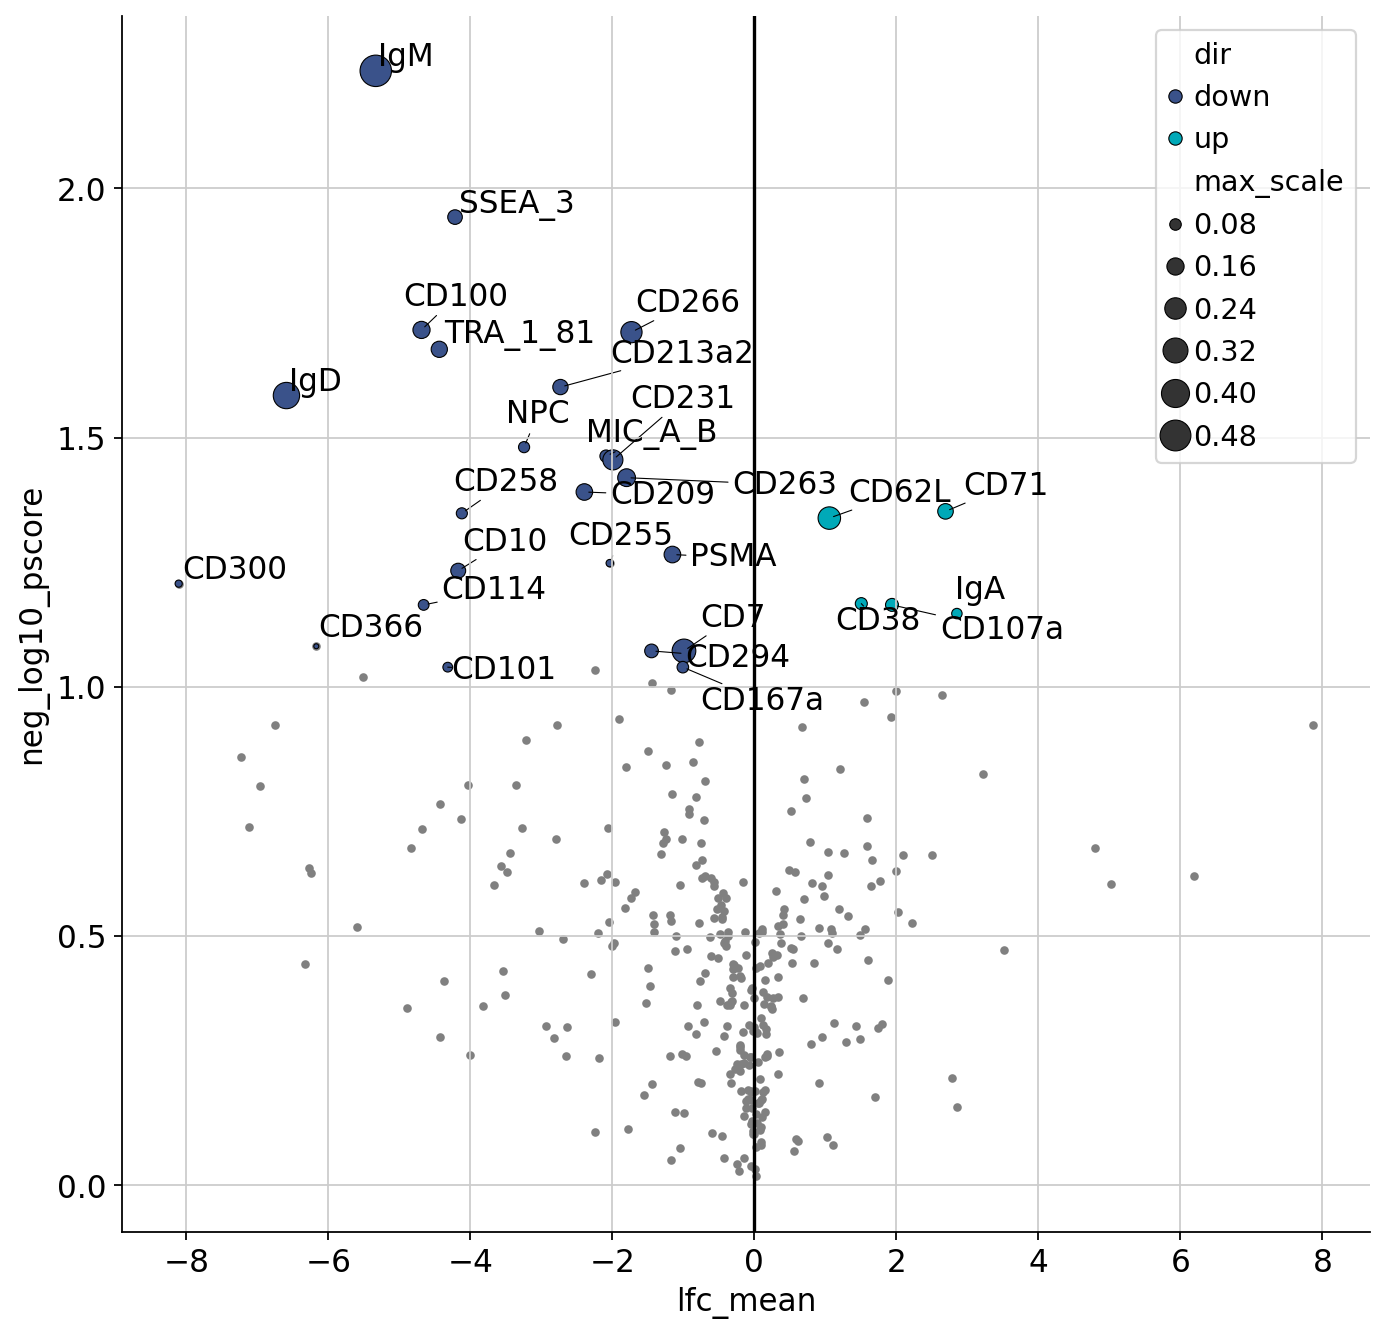

In [13]:
# plot volcano of DE without label overlap
from adjustText import adjust_text

de_df['neg_log10_pscore'] = -np.log10(de_df['proba_not_de'])

de_df['dir'] = ['up' if lfc > 0 else 'down' for lfc in de_df['lfc_mean']]

# obtain max expression across groups
for i, row in de_df.iterrows():
    max_scale = max(row['scale1'], row['scale2'])
    de_df.loc[i, 'max_scale'] = max_scale

palette = ['#3A528A', '#00A9B8']

plt.figure(figsize=(10,10))
sns.scatterplot(data = de_df, x = 'lfc_mean', y = 'neg_log10_pscore', color = 'grey',  edgecolor = None, linewidth = 0, s = 15)
sns.scatterplot(data = de_df[de_df['is_de_fdr_0.05'] == True], x = 'lfc_mean', y = 'neg_log10_pscore', hue = 'dir', size = 'max_scale', palette = palette, edgecolor = 'black', linewidth = 0.5, sizes = (5, 200))
plt.axvline(0, 0, 500, color = 'black')

# Label significant proteins
label_genes = de_df[de_df['is_de_fdr_0.05'] == True].index

# store protein labels
texts = []
for i, row in de_df[de_df.index.isin(label_genes)].iterrows():
    text = plt.text(row['lfc_mean'], row['neg_log10_pscore'], i)
    texts.append(text)

# prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand_axes=True)

plt.savefig(figure_dir + 'volcano_DE_annotated.pdf')

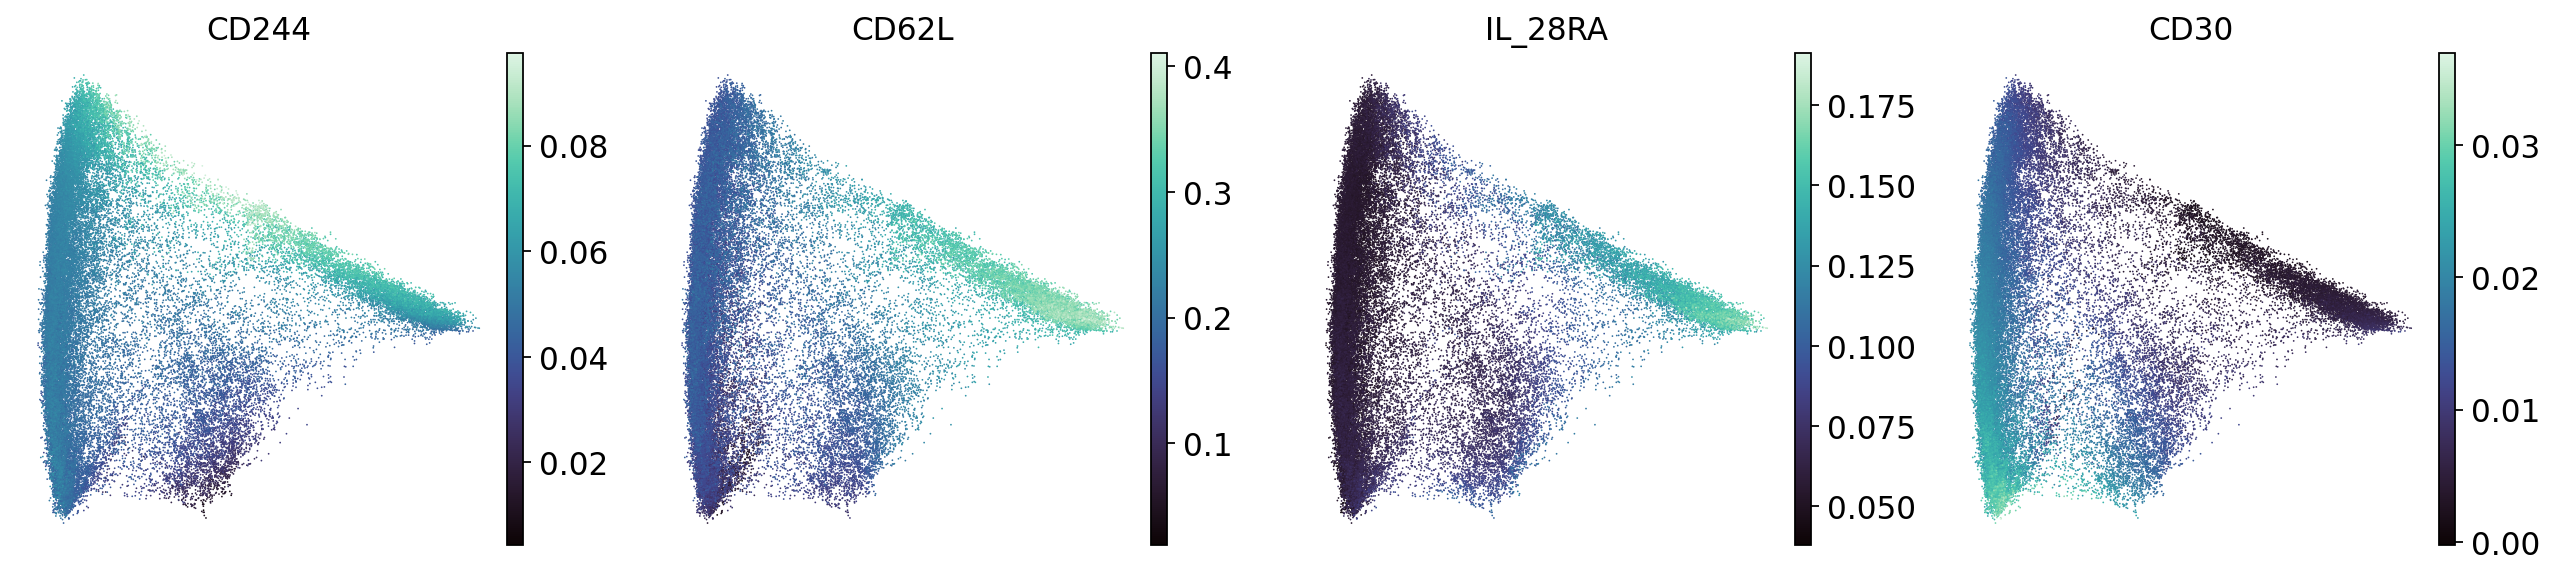

In [70]:

sc.pl.embedding(adata, basis='X_diffmap', color=['CD244', 'CD62L', 'IL_28RA', 'CD30'], dimensions=(1,2), cmap = 'mako', frameon = False, layer = 'imputed')

  0%|          | 0/7 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


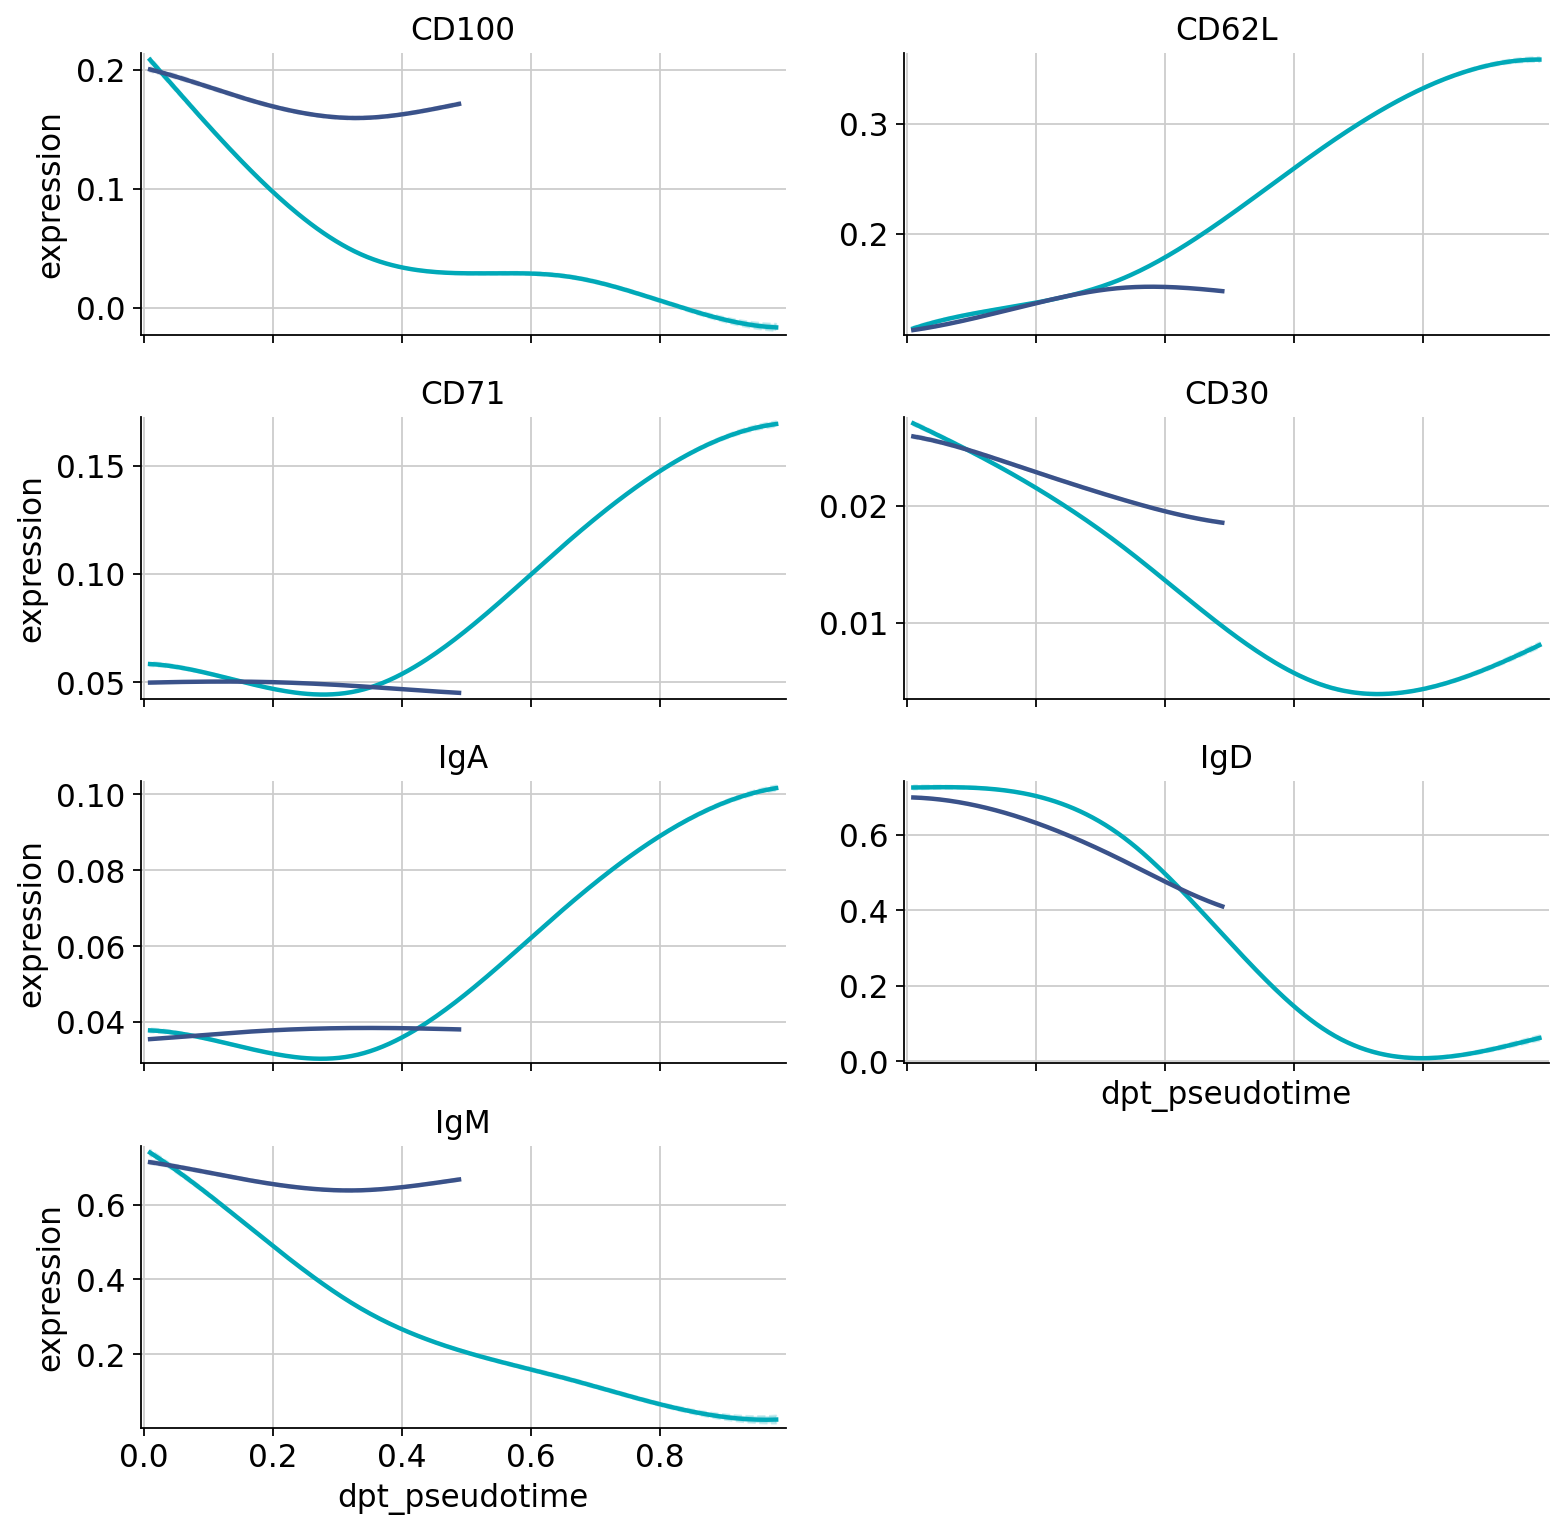

In [28]:
cr.pl.gene_trends(
    adata_sub,
    model=model,
    data_key="imputed",
    genes=['CD100', 'CD62L', 'CD71', 'CD30', 'IgA', 'IgD', 'IgM'],
    same_plot=True,
    ncols=2,
    time_key="dpt_pseudotime",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    save ='gene_trend_plots.pdf',
    figsize = (10, 10),
    legend_loc = None
)